In [1]:
import os
import pandas as pd
import pymongo
import matplotlib.pyplot as plt

os.getcwd()

'C:\\Users\\Alec\\Documents\\Programming_Resources\\Boot_Camp\\personal_projects\\jj_earnings_tracker_LOCAL'

---------------

The first block of Methods takes information from the user to insert into the database

In [2]:
# BLOCK ONE

#-------------------------------------------------------------------------------------------------------------------------#

# set up pymongo connection

# https://docs.mongodb.com/manual/reference/default-mongodb-port/

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# declare database
db = client.jj_earnings

# declare the collections
shifts = db.shifts
test = db.test

# set wages
current_wage = 9.5 
chipotle_wage = 16.5
#-------------------------------------------------------------------------------------------------------------------------#


def get_date():
    # gets the date in a no frills string, formats to desired output for later use
    # returns variable "date_of_shift"
    # breaks if date != 6 characters
    print("Use 2 characters for the Day, Month, and Year.")
    print("EXAMPLE: 01/15/2022 = 011522")
    print("")
    
    date_string = input("Please input date of shift. ")
    
    # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
    if (date_string == "cancel") or (date_string == "exit"):
        return date_string
    
    
    else:
        if len(date_string) != 6:
            raise ValueError ('Date Incorrect Format')
        else:
            month = date_string[slice(0,2)]
            day = date_string[slice(2,4)]
            year = date_string[slice(4,6)]
            date_of_shift = f'{month}-{day}-{year}'
            return date_of_shift

#-------------------------------------------------------------------------------------------------------------------------#

def earnings_request():
    
    '''
    This function passes inputs to user then aggregates the user information, 
    
    then returns a Dictionary of the aggregated information.
    
    '''
    
    # asks for information and returns the date & dict of aggregated values
    wage = current_wage
    date_of_shift = get_date()
    
    # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
    if (date_of_shift == "cancel") or (date_of_shift == "exit"):
        return date_of_shift
    else:
        print("")
        hours = float(input("Hours worked? "))
        if hours <= 0:
            print()
            print('Hours worked cannot be zero - Restart. ')
            raise ValueError
        else:

            # data collection
            tips = float(input("Tips? "))
            start_mileage = input("What was the starting mileage? ")
            end_mileage = input("What was the ending mileage? ")
            start_mileage = int(start_mileage)
            end_mileage = int(end_mileage)
            delta_mileage = end_mileage - start_mileage

            if start_mileage > end_mileage:
                print()
                print('Ending Mileage less than Starting Mileage - Restart')
                raise ValueError

            # data aggregation
            earnings = round(((wage * hours) + tips),2)
            effective_wage = round((earnings / hours), 2)

            old_job_earnings = round((chipotle_wage * hours),2)
            old_job_diff = old_job_earnings - earnings

            # info to return
            entry = {
            "date_of_shift":date_of_shift,
            "tips": tips,
            "hours":hours,
            "earnings":earnings,
            "effective_wage":effective_wage,
            "old_job_earnings":old_job_earnings,
            "old_job_comparison":old_job_diff,
            "starting_mileage": start_mileage,
            "ending_mileage": end_mileage,
            "change_in_mileage": delta_mileage,

            }

    return entry
                

        
#-------------------------------------------------------------------------------------------------------------------------#   return date_of_shift

def main_function():
    '''
    This function sets up two while loops to allow for continual collection of data until a keyword stops the second loop.
    
    The loop collects date, tips earned USD, hours worked, and the starting and ending mileage.
    
    The collected information is aggregated in the earnings_request() method and then sent to a MongoDB for later use.
    
    '''

    finished = 'n'
    # start parent loop
    while finished != 'y':
        loop = True
        # start Child loop
        while loop == True:
            # TRY main data collection 
            # EXCEPT force restart if user input does not meet requirements
            try:
                # run earnings request and pass data to MongoDB after one more user-check.
                shift_data = earnings_request()
                
                # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
                if (shift_data == "cancel") or (shift_data == "exit"):
                    print("Exiting... No Data Saved.")
                    return
                # else no exit string detected, continue operations
                else:
                
                    print('--------------------------------------')
                    print('Please review info, enter "restart" to restart. ')
        
                    # if finished != 'y' keep looping back to line 123
                    # else stop entire loop and do nothing
                    finished = input('Done? (y/n) ').lower()
                    print('--------------------------------------')
                    # in event of user spotted error in data entry that has mis-spelling but meets data parameters
                    # activate EXCEPT and allow for restart
                    if finished == 'restart':
                        raise ValueError
                    else:

                        print('Sending document to jj_earnings in MongoDB...')
                        print('--------------------------------------')
                        print()
                        shifts.insert_one(shift_data)
                        # END child loop - back to parent loop line 123
                        loop = False
                
            except ValueError:
                print('')
                print('====================================')
                print("Incorrect Data Entry, try that again.")
                print('====================================')
                print('')
#-------------------------------------------------------------------------------------------------------------------------#






---------------------------------------

The second block of methods sets up queries for user to access listed databases, collections and documents.

-------------------------------------

In [3]:
# BLOCK TWO

#-------------------------------------------------------------------------------------------------------------------------#
# https://www.w3schools.com/python/python_mongodb_query.asp

def query_database():

    '''
    request a database to view, returns a string to pass to other functions that will perform the pull.
        
        
    '''
    
    dblist = client.list_database_names()

    list_len = len(dblist)
    print(f'{list_len} Databases Found ... ')
    print()
    for name in dblist:
        print(f'-{name}')
        print()
    print('------------------------')

    database_query = input("Which Database would you like to load? Use exact spelling.. ")
    if database_query not in dblist:
        raise ValueError(f'Database "{database_query}" Not Found.')
    else:
        print()
        print(f'Database "{database_query}" Successfully Loaded..')
        print()
        return database_query
    
#-------------------------------------------------------------------------------------------------------------------------#

def query_collections(database_query):
    
    '''
        list all collections in DB
        request db to display collections
        return string of which collection user selected to view documents

    '''
    
    #### add back feature to method?
    
    loop = True
    collection_list = client[database_query].list_collection_names()
    x = len(collection_list)
   
    
    print(f' {x} collection(s) found in "{database_query}"')
    print('------------------------')
    
    # print each collection in list i.e. DB
    for count, collection in enumerate(collection_list):
        
        
        print()
        print(f'{count}-{collection}')
        print()
    print('------------------------')    
    print()
    
   # keep asking the query if the user misspells the collection

    while loop == True:
        try:
            collection_query = input("Which collection would you like to load? ")

            if collection_query not in collection_list:
                raise ValueError("Collection not found, Try again.")
                
            else:
                print("Collection found.")
                loop = False
                return collection_query
                

        except ValueError:
            print()
            print(f'Collection "{collection_query}" not found, Try again.')
            print()
#-------------------------------------------------------------------------------------------------------------------------#

def query_documents(database_query,collection_query):
    '''
    Need to re-write this into a class 
    
    '''

    collection = client[database_query][collection_query]   
    
    documents = collection.find()

    doc_list = []
    for doc in documents:
        doc_list.append(doc)
    return doc_list

#-------------------------------------------------------------------------------------------------------------------------#

def plot_earnings(dataframe):
    # set up plot(s)
    fig = plt.figure(figsize = (19.20,10.80))

    # ------------------------------------ JJ wage ------------------------------------ #

    # set x & y values
    x_date = dataframe['date_of_shift']
    y_jj_earnings = dataframe['earnings']

    plt.plot(x_date,y_jj_earnings \
             ,label = "Jimmy John's Earnings"
             ,marker = "o"
             ,color = "b"
            )


    # ------------------------------------ Lines to display earnings ------------------------------------ #
    avg_earnings = round(dataframe['earnings'].mean(),2)
    
    
#     ------------------------------- Average Earnings ------------------------------- #
    plt.hlines(y= avg_earnings
               ,xmin = x_date[0]
               ,xmax = x_date[len(x_date)-1]
               ,linestyles='solid'
               ,color='k'
               ,label=f'Average Earnings, ${avg_earnings}')

    
    
    # ------------------------------------ Chipotle wage ------------------------------------ #

    y_chipotle_earnings = dataframe['old_job_earnings']


    plt.plot(x_date, y_chipotle_earnings \
             ,label='Chipotle Earnings'
             ,marker='o'
             ,color='r'
             ,linestyle='--'
            )

    # ------------------------------------ Display Plot(s) ------------------------------------ #
    plt.title('Earnings per Shift')
    plt.xlabel('Date of Shift')
    plt.xticks(rotation=45)
    plt.ylabel('Earnings in $USD')
    plt.legend()
    plt.plot()
    plt.grid(True)
    plt.savefig('visualizations/JJ_vs_Chipotle_Earnings.png')
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------#

def display_and_save(name):
 
    dataframe.to_json(f'clean_data/{name}.json',)
    dataframe.to_csv(f'clean_data/{name}.csv')
    print(f'Saving Dataframe "{name}" to JSON & CSV file ... ')
    print()
    return dataframe

#-------------------------------------------------------------------------------------------------------------------------#

-------------------------

# Information Request and Input

In [4]:
documents = query_documents("jj_earnings","shifts")
display(documents[-1])

{'_id': ObjectId('624a6bcdddea857db911f8c3'),
 'date_of_shift': '04-03-22',
 'tips': 143.0,
 'hours': 10.25,
 'earnings': 240.38,
 'effective_wage': 23.45,
 'old_job_earnings': 169.12,
 'old_job_comparison': -71.25999999999999,
 'starting_mileage': 78677,
 'ending_mileage': 78771,
 'change_in_mileage': 94}

main_function()

---------------

# Query time

In [5]:
# database = query_database()
# collection = query_collections(database)
# documents = query_documents(database,collection)

documents = query_documents("jj_earnings","shifts")
display(documents)

[{'_id': ObjectId('61d91ad96ff8d725c83e3302'),
  'date_of_shift': '12-31-21',
  'tips': 41.0,
  'hours': 7.75,
  'earnings': 114.62,
  'effective_wage': 14.79,
  'old_job_earnings': 127.88,
  'old_job_comparison': 13.25,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3303'),
  'date_of_shift': '01-01-22',
  'tips': 45.0,
  'hours': 6.0,
  'earnings': 102.0,
  'effective_wage': 17.0,
  'old_job_earnings': 99.0,
  'old_job_comparison': -3.0,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3304'),
  'date_of_shift': '01-02-22',
  'tips': 71.0,
  'hours': 10.2,
  'earnings': 167.9,
  'effective_wage': 16.46,
  'old_job_earnings': 168.3,
  'old_job_comparison': 0.4,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3305'),
  'date_of_shift': '01-05-22',
  'tips': 71.0,
  'hours': 7.0,
  'earnings'

In [7]:
# create dataframe from the documents, drop columns
dataframe = pd.DataFrame(documents)
# drop _id from dataframe
dataframe = dataframe.drop(columns=['_id'])

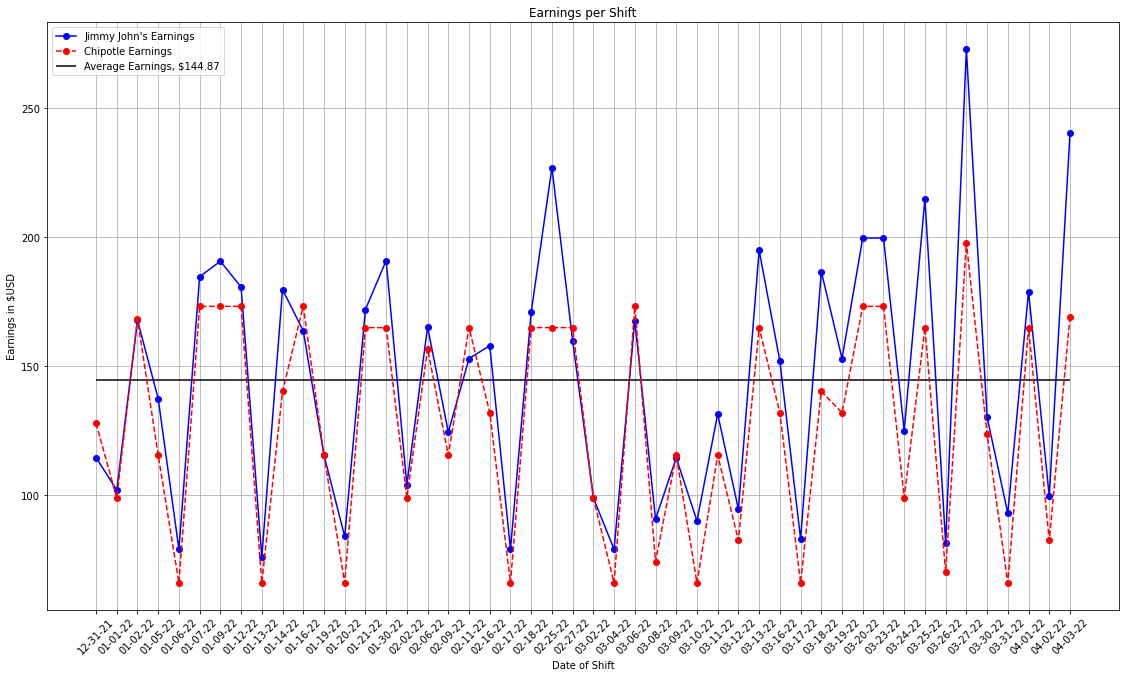

In [8]:
plot_earnings(dataframe)

In [9]:
display_and_save('jj_earnings')

Saving Dataframe "jj_earnings" to JSON & CSV file ... 



,date_of_shift,tips,hours,earnings,effective_wage,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
0,12-31-21,41.0,7.75,114.62,14.79,127.88,13.25,0,0,0
1,01-01-22,45.0,6.00,102.00,17.00,99.00,-3.00,0,0,0
2,01-02-22,71.0,10.20,167.90,16.46,168.30,0.40,0,0,0
3,01-05-22,71.0,7.00,137.50,19.64,115.50,-22.00,75190,75245,55
4,01-06-22,41.0,4.00,79.00,19.75,66.00,-13.00,75255,75290,35
5,01-07-22,85.0,10.50,184.75,17.60,173.25,-11.50,75300,75369,69
6,01-09-22,91.0,10.50,190.75,18.17,173.25,-17.50,75382,75444,62
7,01-12-22,81.0,10.50,180.75,17.21,173.25,-7.50,75448,75523,75
8,01-13-22,38.0,4.00,76.00,19.00,66.00,-10.00,75533,75562,29
9,01-14-22,99.0,8.50,179.75,21.15,140.25,-39.50,75575,75640,65


In [16]:
# ---------------------------------- shift & hours calculations ---------------------------------- #
jj_total_earnings = round(dataframe['earnings'].sum(),2)
jj_num_shifts = dataframe['earnings'].count()
jj_avg_earned_shift = round(dataframe['earnings'].mean(),2)
jj_avg_hourly_wage = round(dataframe['effective_wage'].mean(),2)
avg_miles_driven = round(dataframe['change_in_mileage'].mean(),2)

chip_shift_earnings = 16.5 * (34/4) # 34hrs/wk divided by 4 days worked per week = (8.5)

chip_shift_diff = round((jj_avg_earned_shift - chip_shift_earnings),2)

if chip_shift_earnings > jj_avg_earned_shift:
    pos_neg_shift = "-"
else: pos_neg_shift = "+"

jj_avg_hours_shift = round(dataframe['hours'].mean(),2) # sum hours / sum shifts

jj_avg_hours_week = round(dataframe['hours'].mean(),2) * 5


# ---------------------------------- weekly calculations ---------------------------------- #

jj_avg_earnings_week = round((jj_avg_hours_week * jj_avg_hourly_wage),2)

chip_week_earnings = chip_shift_earnings * 4 # 4 days per week worked

chip_week_diff = round((jj_avg_earnings_week - chip_week_earnings),2)

if chip_week_earnings > jj_avg_earnings_week:
    pos_neg_week = "-"
else: pos_neg_week = "+"

# ---------------------------------- yearly calculations ---------------------------------- #

chip_year = chip_week_earnings * 52
jj_year = jj_avg_earnings_week * 52
chip_year_diff = round((jj_year - chip_year),2)

if chip_year > jj_year:
    pos_neg_year = "-"
else: 
    pos_neg_year = "+"

In [17]:
print('---------------------------------------------------------------------------------------------------------------')
print('                   VOLATILE INFORMATION - SUBJECT TO DRASTIC CHANGE AS DATASET IS BUILT')
print('---------------------------------------------------------------------------------------------------------------')

print(f"Total earnings at JJs in {jj_num_shifts} shifts -> ${jj_total_earnings}")
print(f'')
print(f'You drive {avg_miles_driven} miles per shift on Average.')
print(f'')
print(f"Avg earned per Hour at JJs -> {jj_avg_hourly_wage}")
print(f'')
print(f"Avg hours per Shift at JJs -> {jj_avg_hours_shift}")
print(f'')
print(f'Avg hours per week at JJs -> {jj_avg_hours_week}')
print(f'')
print(f'Average earned per shift at JJs -> ${jj_avg_earned_shift}')
print(f'')
print(f'Avg JJs weekly earnings = ${jj_avg_earnings_week}')
print(f'')
print(f'Avg Chipotle Weekly earnings = ${chip_week_earnings}')
print(f'')
print(f'Per shift take home is {pos_neg_shift} ${chip_shift_diff} in comparison to Chipotle per shift')
print(f'')
print(f'Per week take home is {pos_neg_week} ${chip_week_diff} in comparison to Chipotle, so far.')
print(f'')
print(f'Per year youll make {pos_neg_year} ${chip_year_diff} in comparison to Chipotle, so far.')

---------------------------------------------------------------------------------------------------------------
                   VOLATILE INFORMATION - SUBJECT TO DRASTIC CHANGE AS DATASET IS BUILT
---------------------------------------------------------------------------------------------------------------
Total earnings at JJs in 48 shifts -> $6953.78

You drive 52.67 miles per shift on Average.

Avg earned per Hour at JJs -> 18.89

Avg hours per Shift at JJs -> 7.74

Avg hours per week at JJs -> 38.7

Average earned per shift at JJs -> $144.87

Avg JJs weekly earnings = $731.04

Avg Chipotle Weekly earnings = $561.0

Per shift take home is + $4.62 in comparison to Chipotle per shift

Per week take home is + $170.04 in comparison to Chipotle, so far.

Per year youll make + $8842.08 in comparison to Chipotle, so far.


In [18]:
dataframe.describe()

,tips,hours,earnings,effective_wage,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,71.354167,7.738542,144.870417,18.889792,127.685833,-17.184792,72176.229167,72228.895833,52.666667
std,28.443666,2.521171,49.018645,2.197728,41.599360,19.205650,18863.375284,18877.207197,24.841912
min,38.000000,4.000000,76.000000,14.790000,66.000000,-75.000000,0.000000,0.000000,0.000000
25%,47.750000,5.750000,99.375000,17.207500,94.875000,-26.000000,75768.750000,75812.500000,35.750000
50%,66.500000,8.000000,152.500000,19.010000,132.000000,-13.500000,77034.000000,77077.500000,53.500000
75%,84.250000,10.000000,180.000000,19.967500,165.000000,-6.375000,77838.000000,77927.000000,66.250000
max,159.000000,12.000000,273.000000,23.450000,198.000000,13.250000,78677.000000,78771.000000,102.000000


# TO_DO

# incorporate means of recording the day fo the week using the date entered.

- Enter method for updating mongo entries
    - pull entries
    - update via key:value
        
        
- Add day of week to data
    - import date/time, math your way to the day of the week
    - update the wage to $10 per hour


- expand utility of database_query() by class conversion.

    - explore class concepts and inheritance
    - write/re-write as needed to unbundle the methods and clean up how they function.
    
- examine how change is calculated and decide is the means of chipotle comparision is accurate. 
> Q: should another means be utilized to potentially provide more accurate results

- break down earnings into proper categories
    - tips
    - DMR
    - wage_earnings
    - sum all to create "combined_earnings"

# ------------------------------------ WORK IN PROGRESS ------------------------------------

In [34]:
# create dataframe from the documents, drop columns
dataframe = pd.DataFrame(documents)
# drop _id from dataframe
dataframe = dataframe.drop(columns=['_id'])

# drop outliers in mileage
dataframe = dataframe.loc[dataframe['starting_mileage'] > 0]

dataframe = dataframe.rename(columns={'effective_wage':'wage_DMR+Tips'})

dataframe.insert(2,'tips_less_DMR',dataframe['tips'] - (dataframe['change_in_mileage'] * 0.52))
dataframe.insert(3, 'DMR', (dataframe['change_in_mileage'] * 0.52))
dataframe.insert(5, 'wage_earnings', (dataframe['hours'] * current_wage))
dataframe.insert(5, 'real_wage(no DMR)',round(((dataframe['tips_less_DMR']+dataframe['wage_earnings']) / dataframe['hours']),2) )


dataframe

,date_of_shift,tips,tips_less_DMR,DMR,hours,real_wage(no DMR),wage_earnings,earnings,wage_DMR+Tips,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
3,01-05-22,71.0,42.40,28.60,7.00,15.56,66.500,137.50,19.64,115.50,-22.00,75190,75245,55
4,01-06-22,41.0,22.80,18.20,4.00,15.20,38.000,79.00,19.75,66.00,-13.00,75255,75290,35
5,01-07-22,85.0,49.12,35.88,10.50,14.18,99.750,184.75,17.60,173.25,-11.50,75300,75369,69
6,01-09-22,91.0,58.76,32.24,10.50,15.10,99.750,190.75,18.17,173.25,-17.50,75382,75444,62
7,01-12-22,81.0,42.00,39.00,10.50,13.50,99.750,180.75,17.21,173.25,-7.50,75448,75523,75
8,01-13-22,38.0,22.92,15.08,4.00,15.23,38.000,76.00,19.00,66.00,-10.00,75533,75562,29
9,01-14-22,99.0,65.20,33.80,8.50,17.17,80.750,179.75,21.15,140.25,-39.50,75575,75640,65
10,01-16-22,64.0,30.20,33.80,10.50,12.38,99.750,163.75,15.60,173.25,9.50,75655,75720,65
11,01-19-22,49.0,28.20,20.80,7.00,13.53,66.500,115.50,16.50,115.50,0.00,75735,75775,40
12,01-20-22,46.0,22.60,23.40,4.00,15.15,38.000,84.00,21.00,66.00,-18.00,75780,75825,45


In [35]:
dataframe.describe()

,tips,tips_less_DMR,DMR,hours,real_wage(no DMR),wage_earnings,earnings,wage_DMR+Tips,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,72.622222,43.409778,29.212444,7.722222,15.203333,73.361111,145.983556,19.076889,127.416444,-18.567111,76987.977778,77044.155556,56.177778
std,28.737281,20.678295,11.122017,2.565739,1.780475,24.374522,49.907600,2.127480,42.334739,18.957838,1105.356719,1107.391118,21.388494
min,38.000000,17.600000,4.160000,4.000000,11.820000,38.000000,76.000000,15.300000,66.000000,-75.000000,75190.000000,75245.000000,8.000000
25%,48.000000,28.200000,20.280000,5.000000,13.840000,47.500000,99.000000,17.370000,82.500000,-26.000000,75981.000000,76065.000000,39.000000
50%,68.000000,38.360000,28.600000,8.000000,15.150000,76.000000,153.000000,19.020000,132.000000,-16.000000,77120.000000,77152.000000,55.000000
75%,85.000000,52.320000,34.840000,10.000000,16.640000,95.000000,180.750000,20.170000,165.000000,-7.500000,77922.000000,77972.000000,67.000000
max,159.000000,108.040000,53.040000,12.000000,19.090000,114.000000,273.000000,23.450000,198.000000,12.000000,78677.000000,78771.000000,102.000000


In [36]:
dataframe.sum()

date_of_shift         01-05-2201-06-2201-07-2201-09-2201-12-2201-13-...
tips                                                             3268.0
tips_less_DMR                                                   1953.44
DMR                                                             1314.56
hours                                                             347.5
real_wage(no DMR)                                                684.15
wage_earnings                                                   3301.25
earnings                                                        6569.26
wage_DMR+Tips                                                    858.46
old_job_earnings                                                5733.74
old_job_comparison                                              -835.52
starting_mileage                                                3464459
ending_mileage                                                  3466987
change_in_mileage                                               

from scipy.stats import linregress

print(f'{dataframe.columns}')
print()
x_input = input('X axis for scatter plot? ')
y_input = input('y axis for scatter plot? ')
print()
print()



# drop outliers
dataframe_no_outliers = dataframe.loc[dataframe['change_in_mileage'] > 0]

# set values based on input
x = dataframe_no_outliers[f'{x_input}']
y = dataframe_no_outliers[f'{y_input}']


# set figure params
fig = plt.figure(figsize = (19.20,10.80))
plt.grid()

#plot scatter
plt.scatter(x,y)

plt.xlabel(f'{x_input}')
plt.ylabel(f'{y_input}')


plt.show()

import seaborn as sn
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (19.20,10.80))

corrMatrix = dataframe.corr()
sn.heatmap(corrMatrix, annot=True)
plt.savefig('visualizations/heatmap_correlations.png')

# --------------------------------- END WORK IN PROGRESS --------------------------------